In [1]:
import scanpy as sc
import pandas as pd

import seaborn as sns
from matplotlib import rcParams
import numpy as np

In [2]:
!ls -lha ../data/*

-rw-rw-r-- 1 ing ing 9.4M Nov 29 14:43 ../data/all_cells.csv
-rw-rw-r-- 1 ing ing 4.1M Nov 29 14:20 ../data/epithelial_compartment.csv
-rw-rw-r-- 1 ing ing 160K Nov 29 14:29 ../data/fibroblast_compartment.csv
-rw-rw-r-- 1 ing ing 356K Nov 29 14:38 ../data/immune_compartment.csv
-rw-rw-r-- 1 ing ing 1.7G Nov 29 13:05 ../data/MIBC_snSeq.h5ad
-rw-rw-r-- 1 ing ing 2.1M Nov 29 16:15 ../data/non_tumor_all_cells.csv
-rw-rw-r-- 1 ing ing 918K Nov 29 16:33 ../data/non_tumor_epithelial_compartment.csv
-rw-rw-r-- 1 ing ing 304M Nov 29 16:15 ../data/non_tumor_snSeq.h5ad


In [3]:
!md5sum ../data/*

66b991da2983dc7e19a5913d38daa78e  ../data/all_cells.csv
f2778dcb9c9d88fe7ee29ab6df3906db  ../data/epithelial_compartment.csv
4b52e9ad8ae2e03a8a6dba729859a739  ../data/fibroblast_compartment.csv
5c06539ba6409c84f8808e381c0e5d14  ../data/immune_compartment.csv
b5affa11fca0f9ca461ca0408530cd21  ../data/MIBC_snSeq.h5ad
0b7beee075374e03bb5ea2a1f3b2775e  ../data/non_tumor_all_cells.csv
ac55aeaaf23fdc168c38b9fa66f202da  ../data/non_tumor_epithelial_compartment.csv
dd35d700e909d46f081b699690de7e88  ../data/non_tumor_snSeq.h5ad


(67988, 33538)
(4893, 4)
(4893, 33538)


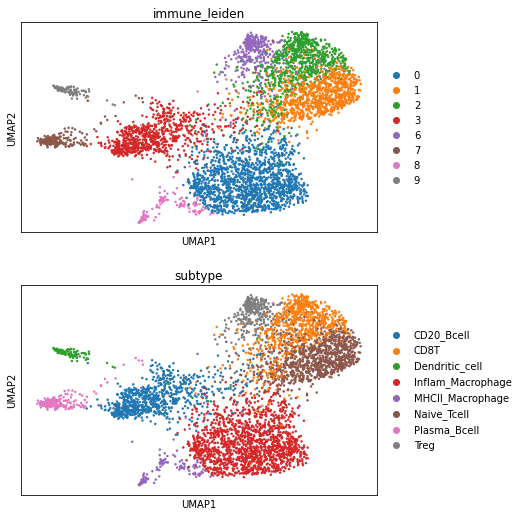

In [4]:
ad = sc.read_h5ad("../data/MIBC_snSeq.h5ad")
print(ad.shape)
obs = pd.read_csv("../data/immune_compartment.csv", index_col=0, header=0)
print(obs.shape)
ad = ad[obs.index].copy()
print(ad.shape)

sc.pp.normalize_total(ad, target_sum=10000)
sc.pp.log1p(ad)

ad.obs['immune_leiden'] = pd.Categorical(obs['immune_leiden'].values)
ad.obsm['X_umap'] = obs.loc[:, ['umap_1', 'umap_2']].values
sc.pl.umap(ad, color=['immune_leiden', 'subtype'], ncols=1)

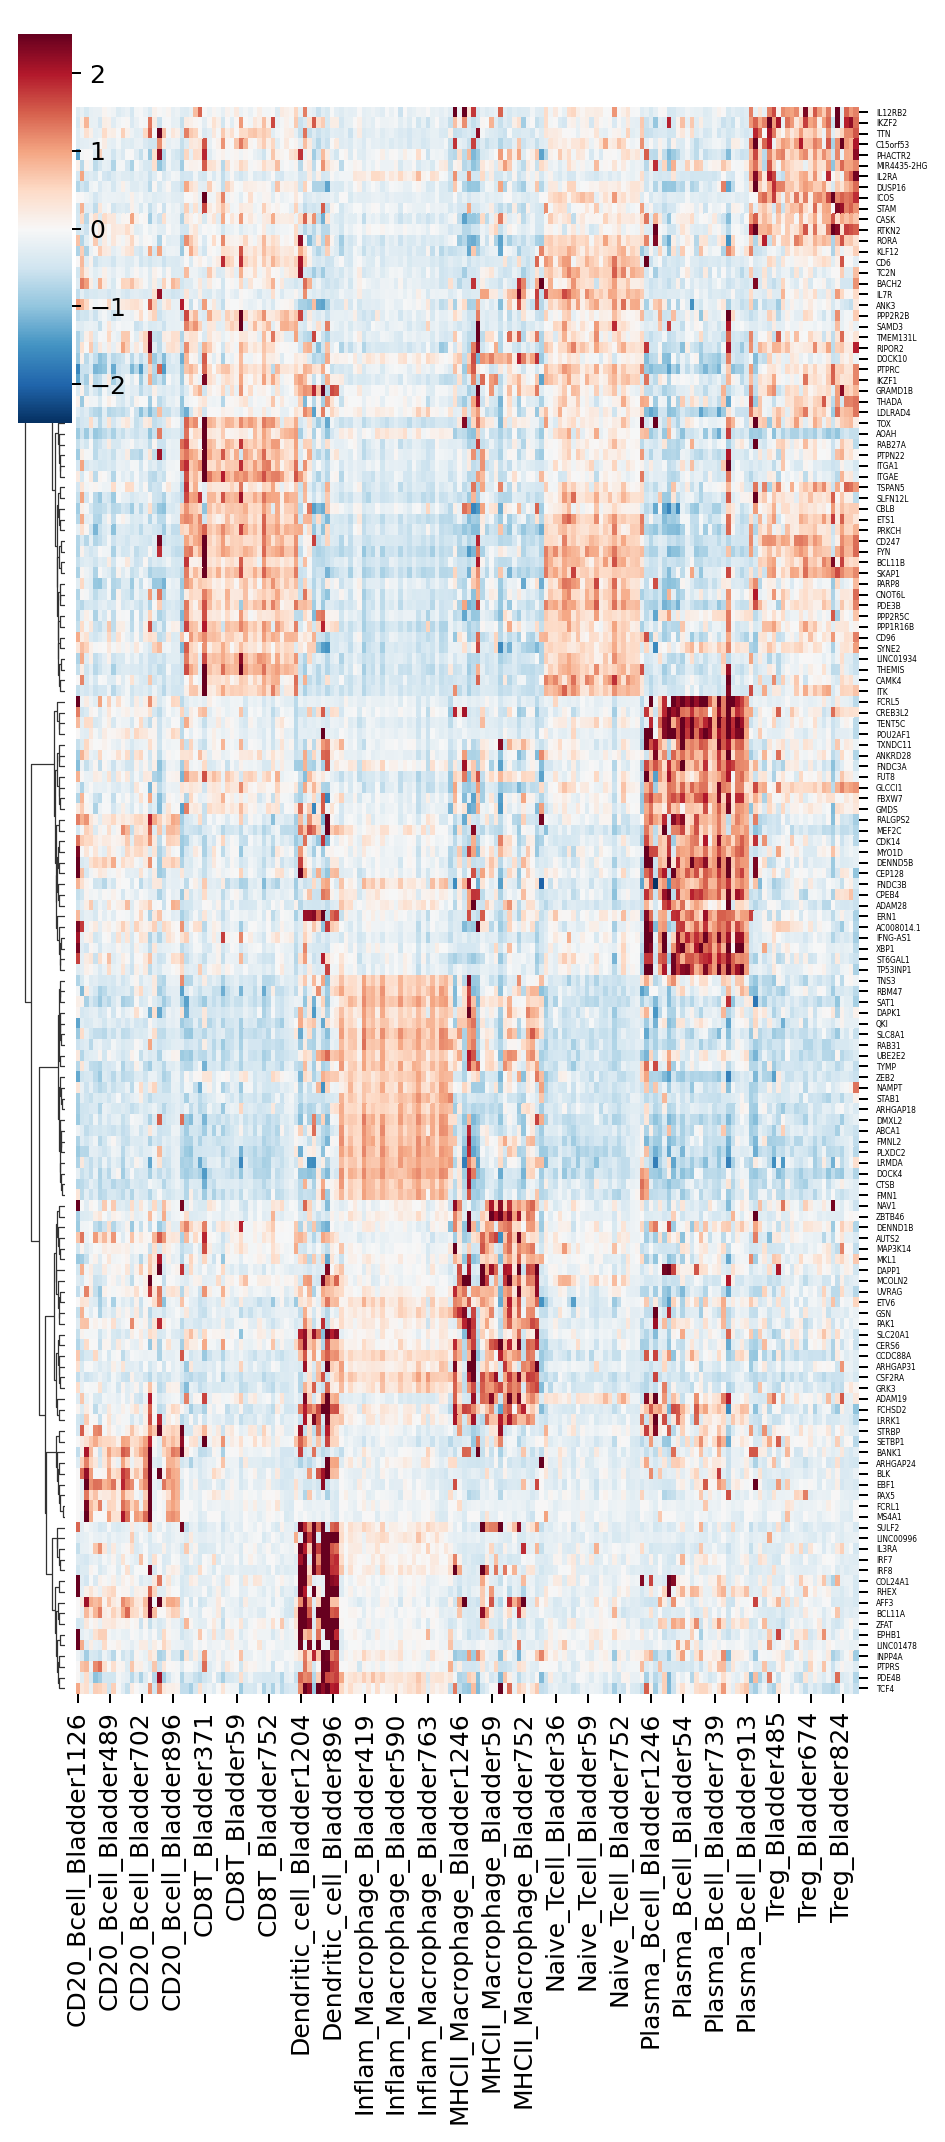

In [7]:
dgex_matrix = pd.read_csv('Immune_DGEX.csv')
grp = dgex_matrix.group.unique().tolist()
marker_genes = []
for g in grp:
    marker_genes = marker_genes + dgex_matrix[(dgex_matrix.group==g)].names[:20].tolist()
marker_genes = np.unique(marker_genes)

gex = []
for pt in np.unique(ad.obs.Patient):
    if (ad.obs.Patient==pt).sum() < 10:
        continue
    ad_pt = ad[ad.obs.Patient==pt, ad.var_names.isin(marker_genes)].copy()
    sc.pp.scale(ad_pt, zero_center=True)
    gex_pt = pd.DataFrame(ad_pt.X, index=ad_pt.obs_names, columns=ad_pt.var_names)
    gex_pt['cluster'] = ad_pt.obs['subtype']
    gex_pt = gex_pt.groupby('cluster').mean()
    gex_pt.index = [f'{i}_{pt}' for i in gex_pt.index]
    gex.append(gex_pt.copy())
    
gex = pd.concat(gex, axis=0)
gex = gex.sort_index()

rcParams['figure.dpi'] = 180
ax = sns.clustermap(gex.T, z_score=None, cmap='RdBu_r', col_cluster=False, vmax=2.5, vmin=-2.5, 
                    yticklabels=True, dendrogram_ratio=0.05, figsize=(6, 12), method='ward'
                   )
_ = ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=3)